In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import os
import sys
import struct
data = np.load('mnist.npz')
%matplotlib inline

In [26]:
def relu(x):
    return (x > 0) * x

def softmax(x, axis=1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def onehot(y, n_classes):
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

# Data Preparation 

#### reading data and preparing the test, train and validation sets

In [32]:
def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)


os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')

train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'train-images-idx3-ubyte.gz'

In [38]:
data = np.load('mnist.npz')
X_train = data['x_train'][:48000].reshape(48000, 784)
y_train = data["y_train"][:48000]
X_valid = data['x_train'][48000:].reshape(12000, 784)
y_valid = data["y_train"][48000:]

X_test = data['x_test'].reshape(10000, 784)
y_test = data['y_test']

y_train_onehot = onehot(y_train, 10)
y_valid_onehot = onehot(y_valid, 10)
y_test_onehot = onehot(y_test, 10)

In [86]:
class MLP:
    
      
    def __init__(self, init_method, input_size = 784, hidden_size = 512, output_size = 10, 
                 hidden_dims=(512,512), n_hidden=2, mode='train', datapath=None, model_path=None):
        
        self.W1 = np.random.normal(0, 1, (hidden_dims[0], input_size))
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.normal(0, 1, (hidden_dims[0], hidden_dims[1]))
        self.b2 = np.zeros(hidden_size)
        self.W3 = np.random.normal(0, 1, (output_size, hidden_dims[1]))
        self.b3 = np.zeros(output_size)
        
        d0_Glorat = np.sqrt(6 / input_size + hidden_size)
        self.W1 = np.random.uniform(-d0_Glorat, d0_Glorat, size=(hidden_size, input_size))
        self.b1 = np.zeros(hidden_size)
        d1_Glorat = np.sqrt(6 / hidden_size + hidden_size)
        self.W2 = np.random.uniform(-d1_Glorat, d1_Glorat, size=(hidden_size, hidden_size))
        self.b2 = np.zeros(hidden_size)
        d2_Glorat = np.sqrt(6 / output_size + hidden_size)
        self.W3 = np.random.uniform(-d2_Glorat, d2_Glorat, size=(output_size, hidden_size))
        self.b3 = np.zeros(output_size)

        self.parameters = [self.b1, self.W1, self.b2, self.W2, self.b3, self.W3]
        
  
    def forward(self, x):
        y_1 = np.dot(x, self.W1.T) + self.b1
        r_1 = relu(y_1)
        y_2 = np.dot(r_1, self.W2.T) + self.b2
        r_2 = relu(y_2)
        y_3 = np.dot(r_2, self.W3.T) + self.b3      
        os = softmax(y_3, axis=1)
        return y_1, r_1,  y_2, r_2,  y_3, os
    
    def backward(self, y, x, y_1, r_1,  y_2, r_2,  y_3,  os, weight_decay=0):
        bs = x.shape[0]
        y = np.argmax(y, axis = 1)
        loss, d_y_3 = self.softmax_loss(y_3, y)
        d_r_2 = np.dot(d_y_3, self.W3)
        d_y_2 = (y_2 > 0) * d_r_2
        d_r_1 = np.dot(d_y_2, self.W2)
        d_y_1 = (y_1 > 0) * d_r_1
        
        d_W3 = np.dot(d_y_3.T, r_2) / bs + weight_decay * self.W3
        d_b3 = d_y_3.mean(axis=0)
        d_W2 = np.dot(d_y_2.T, r_1) / bs + weight_decay * self.W2
        d_b2 = d_y_2.mean(axis=0)
        d_W1 = np.dot(d_y_1.T , x) / bs + weight_decay * self.W1
        d_b1 = d_y_1.mean(axis=0)
        return d_b1, d_W1, d_b2, d_W2, d_b3, d_W3
    
    
    def softmax_loss(self, x, y):
        """
        Computes the loss and gradient for softmax classification.
        Inputs:
        - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
          class for the ith input.
        - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
          0 <= y[i] < C
        Returns a tuple of:
        - loss: Scalar giving the loss
        - dx: Gradient of the loss with respect to x
        """
        shifted_logits = x - np.max(x, axis=1, keepdims=True)
        Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
        log_probs = shifted_logits - np.log(Z)
        probs = np.exp(log_probs)
        N = x.shape[0]
        loss = -np.sum(log_probs[np.arange(N), y]) / N
        dx = probs.copy()
        dx[np.arange(N), y] -= 1
        dx /= N
        return loss, dx

    
    def loss(self, os, y):
        return (y * (-np.log(os))).sum(axis=1).mean(axis=0)            
        
    def train(self, data, target, mb_size=100, learning_rate=1e-1, weight_decay=0.):
        for i in range(data.shape[0] // mb_size):
            xi = data[i*mb_size:(i+1)*mb_size]
            yi = target[i*mb_size:(i+1)*mb_size]
            y_1, r_1,  y_2, r_2,  y_3, os = self.forward(xi)
            average_grads = self.backward(yi, xi,  y_1, r_1,  y_2, r_2,  y_3, os , weight_decay)
            average_loss = self.loss(os, yi)
            for p, grad in zip(self.parameters, average_grads):
                p -= learning_rate * grad
        return average_loss
    
    def mat_predict(self, x):
        _, _, _, _, _, os = self.forward(x)
        return os.argmax(axis=1)
    
    def test(self, x, y):
        _, _, _, _, _, os = self.forward(x)
        return self.loss(os, y), os.argmax(axis=1)

In [87]:
def run(init_method, num_epoche = 3):
    mlp = MLP(init_method = init_method)
    train_accuracies, train_losses = [], []
    valid_accuracies, valid_losses = [], []
    test_accuracies, test_losses = [], []

    for e in range(num_epoche):
        loss = mlp.train(X_train, y_train_onehot, mb_size=100, learning_rate=1e-1)

        loss_train, pred_train = mlp.test(X_train, y_train_onehot)
        loss_valid, pred_valid = mlp.test(X_valid, y_valid_onehot)
        loss_test, pred_test = mlp.test(X_test, y_test_onehot)
        valid_losses.append(loss_valid)
        test_losses.append(loss_test)
        valid_accuracies.append((pred_valid == y_valid).mean())
        test_accuracies.append((pred_test == y_test).mean())
        train_losses.append(loss_train)
        train_accuracies.append((pred_train == y_train).mean())
        
    ### Plotting the loss and accuracy
    plt.figure(figsize=(12, 4))
    axis = plt.subplot(1, 2, 1)
    axis.plot(range(1, len(train_losses)+1), train_losses, label='train')
    axis.plot(range(1, len(valid_losses)+1), valid_losses, label='valid')
    axis.plot(range(1, len(test_losses)+1), test_losses, label='test')
    axis.legend()
    axis.set_ylabel('Loss')
    axis.set_xlabel('Epochs')
    axis = plt.subplot(1, 2, 2)
    axis.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train')
    axis.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid')
    axis.plot(range(1, len(test_accuracies)+1), test_accuracies, label='test')
    axis.legend()
    axis.set_ylabel('Accuracy')
    axis.set_xlabel('Epochs')

    
    

In [74]:
a = np.array([[1,2,5], [3,4, 1]])

In [75]:
b = np.argmax(a, axis=1)
b

array([2, 1])

/Users/paquet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log
/Users/paquet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in multiply


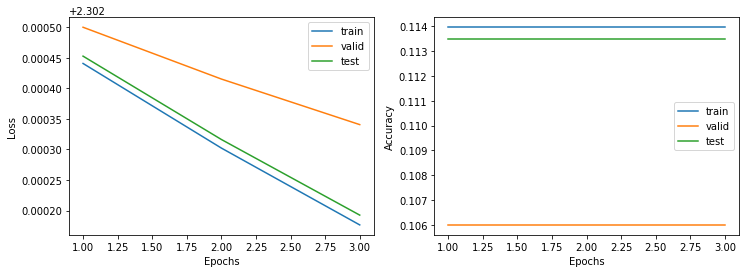

In [88]:
run(init_method = "uniform")